In [1]:
import pandas as pd

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from datetime import datetime

# Replace this to use Noisy QLSTM
# from QLSTM_Noisy import SequenceDataset
from QLSTM import SequenceDataset

In [2]:
df = pd.read_csv('./AAPL_2022-01-01_2023-01-01.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,177.830002,182.880005,177.710007,182.009995,179.724533,104487900
1,2022-01-04,182.630005,182.940002,179.119995,179.699997,177.443542,99310400
2,2022-01-05,179.610001,180.169998,174.639999,174.919998,172.723587,94537600
3,2022-01-06,172.699997,175.300003,171.639999,172.000000,169.840256,96904000
4,2022-01-07,172.889999,174.139999,171.029999,172.169998,170.008102,86709100


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       251 non-null    object 
 1   Open       251 non-null    float64
 2   High       251 non-null    float64
 3   Low        251 non-null    float64
 4   Close      251 non-null    float64
 5   Adj Close  251 non-null    float64
 6   Volume     251 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


In [5]:
df=df[:36]

In [6]:
columns = ['Open', 'High', 'Low', 'Close']

In [7]:
data = df[columns]
data.head()

,Open,High,Low,Close
0,177.830002,182.880005,177.710007,182.009995
1,182.630005,182.940002,179.119995,179.699997
2,179.610001,180.169998,174.639999,174.919998
3,172.699997,175.300003,171.639999,172.000000
4,172.889999,174.139999,171.029999,172.169998


In [8]:
data.head()

,Open,High,Low,Close
0,177.830002,182.880005,177.710007,182.009995
1,182.630005,182.940002,179.119995,179.699997
2,179.610001,180.169998,174.639999,174.919998
3,172.699997,175.300003,171.639999,172.000000
4,172.889999,174.139999,171.029999,172.169998


In [9]:
dataset = data.values

In [10]:
dataset

array([[177.83000183, 182.88000488, 177.71000671, 182.00999451],
       [182.63000488, 182.94000244, 179.11999512, 179.69999695],
       [179.61000061, 180.16999817, 174.63999939, 174.91999817],
       [172.69999695, 175.30000305, 171.63999939, 172.        ],
       [172.88999939, 174.13999939, 171.02999878, 172.16999817],
       [169.08000183, 172.5       , 168.16999817, 172.19000244],
       [172.32000732, 175.17999268, 170.82000732, 175.08000183],
       [176.11999512, 177.17999268, 174.82000732, 175.52999878],
       [175.77999878, 176.61999512, 171.78999329, 172.19000244],
       [171.33999634, 173.77999878, 171.08999634, 173.07000732],
       [171.50999451, 172.53999329, 169.41000366, 169.80000305],
       [170.        , 171.08000183, 165.94000244, 166.22999573],
       [166.97999573, 169.67999268, 164.17999268, 164.50999451],
       [164.41999817, 166.33000183, 162.30000305, 162.41000366],
       [160.02000427, 162.30000305, 154.69999695, 161.61999512],
       [158.97999573, 162

In [11]:
# Splitting the data into train and test
size = int(len(df) * 0.7)
df_train = dataset[:size].copy()
df_test = dataset[size:].copy()

In [12]:
# Select the features
df_train = pd.DataFrame(df_train, columns=columns)
df_test = pd.DataFrame(df_test, columns=columns)

features = df_train.columns
target = 'Close'

In [13]:
def normalize(a, min_a=None, max_a=None):
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

In [14]:
# Normalizing the data
df_train, min_train, max_train = normalize(df_train)
df_test, _, _ = normalize(df_test, min_train, max_train)

In [15]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 4])
Target shape: torch.Size([1])


In [16]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function): 
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [17]:
from QLSTM import QShallowRegressionLSTM

learning_rate = 0.01
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(
    num_sensors=len(features), 
    hidden_units=num_hidden_units, 
    n_qubits=7,
    n_qlayers=1
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 7)


In [18]:
# Count number of parameters
num_params = sum(p.numel() for p in Qmodel.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 292


In [19]:
quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")
# start = time.time()
# test_loss = test_model(test_loader, Qmodel, loss_function)
# end = time.time()
# print("Execution time", end - start)
# quantum_loss_test.append(test_loss)

num_epochs = 5 # 50

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

Untrained test
--------
Epoch 0
---------
Train loss: 0.2079641521163285
Test loss: 0.04606334782544185
Execution time 46.03912711143494
Epoch 1
---------
Train loss: 0.06888077592477203
Test loss: 0.028885672220812095
Execution time 43.29296159744263
Epoch 2
---------
Train loss: 0.04795075403060764
Test loss: 0.022237212920365644
Execution time 45.069756746292114
Epoch 3
---------
Train loss: 0.029669357191814925
Test loss: 0.011136306456054708
Execution time 44.04217219352722
Epoch 4
---------
Train loss: 0.020059172213909734
Test loss: 0.012765579393029147
Execution time 44.92648124694824


In [20]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model Forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_eval_loader, Qmodel).numpy()

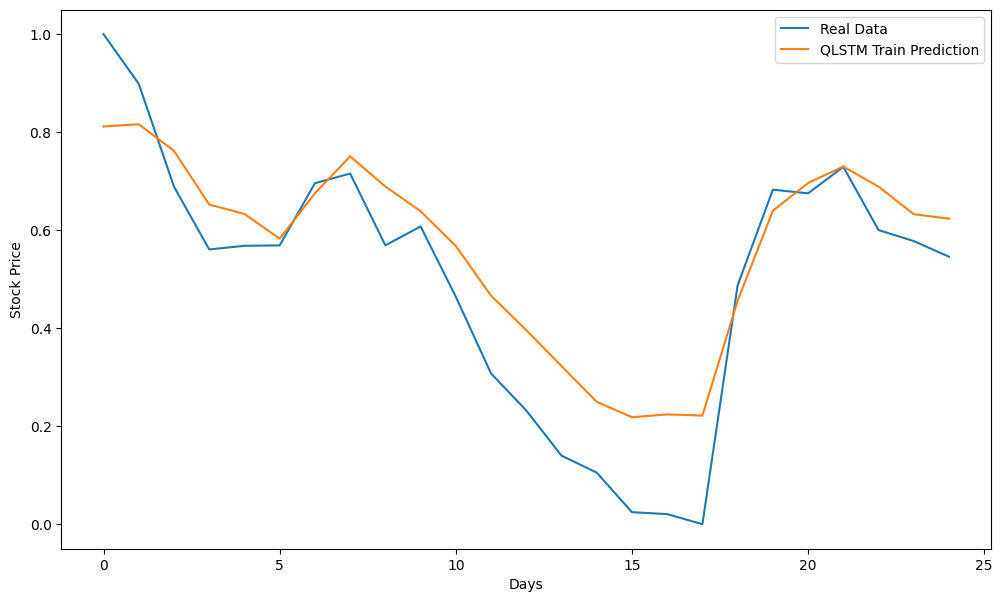

In [21]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_train)), df_train["Close"], label = "Real Data")
plt.plot(range(len(df_train)), df_train["Model Forecast"], label = "QLSTM Train Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend()
plt.show()

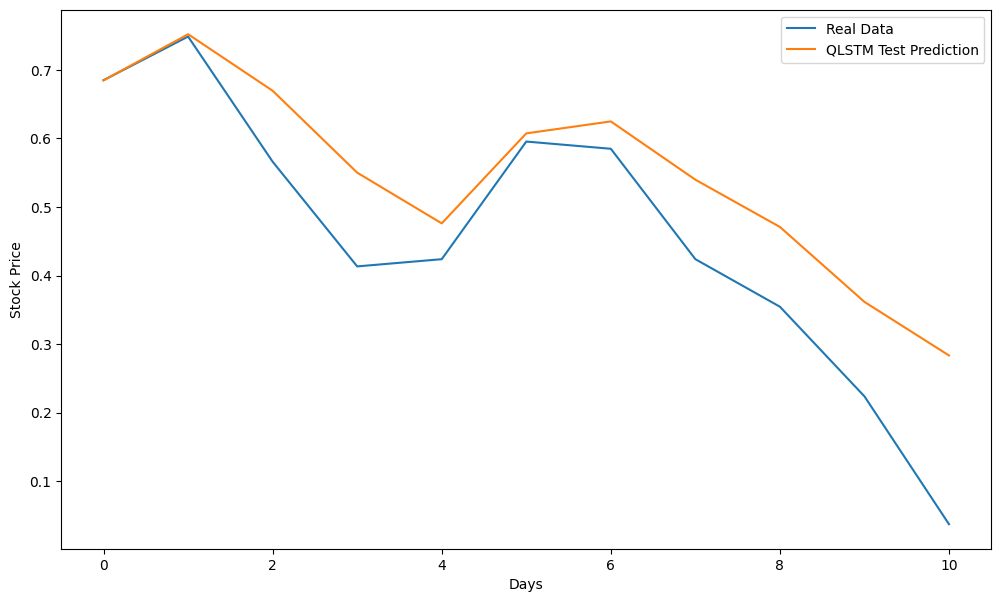

In [22]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_test)), df_test["Close"], label = "Real Data")
plt.plot(range(len(df_test)), df_test["Model Forecast"], label = "QLSTM Test Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend() 
plt.show()

In [23]:
# Calculate the RMSE for the train and test data
from sklearn.metrics import mean_squared_error

train_rmse = math.sqrt(mean_squared_error(df_train["Close"], df_train["Model Forecast"]))
test_rmse = math.sqrt(mean_squared_error(df_test["Close"], df_test["Model Forecast"]))
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.11709560278520818
Test RMSE: 0.11298486225493312


In [24]:
# Calculate the accuracy of the model
def accuracy(y, y_star):
    return np.mean(np.abs(y - y_star) < 0.1)

train_accuracy = accuracy(df_train["Close"], df_train["Model Forecast"])
test_accuracy = accuracy(df_test["Close"], df_test["Model Forecast"])
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

Train accuracy: 0.6
Test accuracy: 0.45454545454545453


In [25]:
# Save the trained model
torch.save(Qmodel.state_dict(), "QLSTM_Stock_Price_Model.pt")